In [1]:
import scipy.signal as signal 

In [174]:
import pandas as pd
from scipy.ndimage import filters
import soundfile as sf
import tftb
from tftb.processing import PseudoWignerVilleDistribution,smoothed_pseudo_wigner_ville
from measure_horseshoe_bat_calls.simulate_calls import make_cffm_call
from measure_horseshoe_bat_calls.signal_processing import *
from measure_horseshoe_bat_calls.view_horseshoebat_call import *
from measure_horseshoe_bat_calls.user_interface import segment_and_measure_call
from measure_horseshoe_bat_calls.batch_processing import load_raw_audio
from measure_horseshoe_bat_calls.segment_horseshoebat_call import *

In [3]:
%matplotlib notebook

In [4]:
def segment_and_show_cffm(call_and_fs, **kwargs):
    ''' Function taken from notebook: Trying out new world bat recordings...'''
    call, fs = call_and_fs
    peak_freq, _ = get_peak_frequency(call, fs)
    (cf,fm,_), _ , measurements,_ = segment_and_measure_call(call,fs,**kwargs)
    w,s = visualise_call(call,fs)
    s.set_ylim(20000,peak_freq*1.5)
    w.plot(make_x_time(call,fs),cf*np.max(call), 'k', label='CF')
    w.plot(make_x_time(call,fs),fm*np.max(call), 'r', label='FM')
    w.legend()
    s.plot(make_x_time(call,fs),cf*peak_freq*1.1, 'w')
    s.plot(make_x_time(call,fs),fm*peak_freq*1.1, 'r')
    return w,s 

<IPython.core.display.Javascript object>


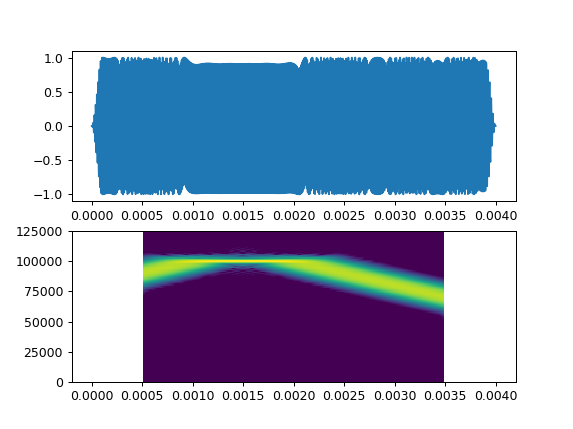

(0, 125000)

In [5]:
call_parameters = {'cf':(100000, 0.001),
                    'upfm':(80000, 0.001),
                    'downfm':(60000, 0.002),
                    }

syn_fs = 500*10**3 # 500kHz sampling rate
synthetic_call, freq_profile = make_cffm_call(call_parameters, syn_fs)
synthetic_call *= signal.tukey(synthetic_call.size, 0.05)
# plot
wavef, spec = visualise_call(synthetic_call, syn_fs, fft_size=512)
spec.set_ylim(0,125000)


### Tracking frequency of a natural bat call:

In [6]:
filename = 'gg_leporinus4_4603-4621ms_GG-USG2017-03-17_20-27-53_0038verygood_snippet.wav'
fs = sf.info(filename).samplerate
leporinus, _ = sf.read(filename, start=int(0.0018*fs), stop=-int(0.002*fs))

<IPython.core.display.Javascript object>


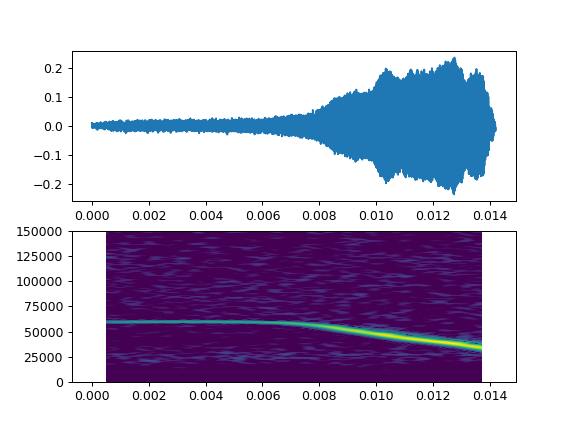

(<matplotlib.axes._subplots.AxesSubplot at 0x13de6fc8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13f9ca88>)

In [7]:
visualise_call(leporinus, fs)


This kind of call (from *N. leporinus* isn't handled well, because it's got an odd envelope. Even though the CF is *not* short, the tail FM is so dominant that the peak frequency gets shifted below. 

In [93]:
def instantaneous_frequency_profile(audio, fs, **kwargs):
    '''Calcualtes the instant frequency across the input audio and pads one sample
    to keep the output size the same as input. 
    
    This code is heavily based on the scipy.signal example here
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html

    Parameters
    -----------
    audio : np.arary
    fs : float>0

    Returns
    -------
    instant_frequency_resized : np.array
        Frequency of audio across the samples in Hz.
    '''
    hil = signal.hilbert(audio)
    instantaneous_phase = np.unwrap(np.angle(hil))
    instantaneous_frequency = (np.diff(instantaneous_phase)/(2.0*np.pi)) * fs
    instant_frequency_resized = resize_by_adding_one_sample(instantaneous_frequency, audio, **kwargs)
    return instant_frequency_resized


def inst_freq_pwvd(audio, fs, **kwargs):
    '''
    '''
    pwvd = PseudoWignerVilleDistribution(audio)
    
    pass



def calc_proper_kernel_size(durn, fs):
    '''scipy.signal.medfilt requires an odd number of samples as
    kernel_size. This function calculates the number of samples
    for a given duration which is odd and is close to the 
    required duration. 
    
    Parameters
    ----------
    durn : float
        Duration in seconds. 
    fs : float
        Sampling rate in Hz
    
    Returns
    -------
    samples : int
        Number of odd samples that is equal to or little 
        less (by one sample) than the input duration. 
    '''
    samples = int(durn*fs)
    if np.remainder(samples,2)==0:
        samples -= 1
    return samples

def resize_by_adding_one_sample(input_signal, original_signal, **kwargs):
    '''Resizes the input_signal to the same size as the original signal by repeating one
    sample value. The sample value can either the last or the first sample of the input_signal. 
    '''
    check_signal_sizes(input_signal, original_signal)
    
    repeat_start = kwargs.get('repeat_start', True)
    
    if repeat_start:
        return np.concatenate((np.array([input_signal[0]]), input_signal))
    else:
        return np.concatenate((input_signal, np.array([input_signal[-1]])))


def check_signal_sizes(input_signal, original_signal):
    if int(input_signal.size) >= int(original_signal.size):
        msg1 = 'The input signal"s size %d'%int(input_signal.size)
        msg2 = ' is greater or equal to the original signal"s size: %d'%(int(original_signal.size))
        raise ValueError(msg1+msg2)
    
    if int(original_signal.size) - int(input_signal.size) >= 2:
        raise ValueError('The original signal is >= 2 samples longer than the input signal.')
    

def median_filter(input_signal, fs, **kwargs):
    '''Median filters a signal according to a user-settable
    window size. 

    Parameters
    ----------
    input_signal : np.array
    fs : float
        Sampling rate in Hz.
    medianfilter_size : float, optional
        The window size in seconds. Defaults to 0.001 seconds. 

    Returns
    -------
    med_filtered : np.array
        Median filtered version of the input_signal. 
    '''
    window_duration = kwargs.get('medianfilter_size',
                              0.001)
    kernel_size = calc_proper_kernel_size(window_duration, fs)
    med_filtered = signal.medfilt(input_signal, kernel_size)
    return med_filtered

def identify_cffm_ish_regions(audio, frequency_profile, fs, **kwargs):
    '''Identifies CF regions by comparing the rate of frequency modulation 
    across the signal. If the frequency modulation within a region of 
    the signal is less than the limit then it is considered a CF region. 

    Parameters
    ----------
    audio : np.array
    frequency_profile : np.array
        The instantaneous frequency of the signal over time in Hz. 
    fm_limit : float, optional 
        The maximum rate of frequency modulation in Hz/s. 
        Defaults to 1000 Hz/s
    relevant_band : list, array-like
        The minimum and maximum frequencies that are relevant for the 
        signal. The FM rate of the frequency profile is calculated only
        within the relevant band. Any parts of the frequency profile 
        out of the relevant band are set to 0. 
        Defaults to (0, fs*0.5)
    noise_level : float, optional
        The background noise level in dB re 1. Only regions with 
        an amplitude >= the noise_level will be considered for 
        labelling as CF/FM. 

    medianfilter_size : float, optional
    

    Returns
    -------
    cfish_regions, fmish_regions: np.array
        Boolean array where True indicates the sample is a member of that element.  
        The output may still need to be cleaned before final use. 
    clean_fmrate_resized : np.array
        Frequency modulation rate in Hz/s
    
    Notes
    -----
    * Estimating the exact FM modulation rate required for your particular call/sound 
    may be tricky. Some times these rates are available in the literature, but otherwise
    the easiest thing to do is to load the audio file onto a graphical audio analysis 
    software like Audacity and look and start and end frequencies of the FM segments
    and divide the difference by the time between the two. This will already give a
    ball park estimate. 
    
    If you're used to reading FM modulation rates in kHz/ms then just 
    follow this relation to get the required modulation rate in Hz/s:
    
    X Hz/s = (X kHz/ms) * 10^6
    
    * The median filter size setting plays a big role in how well the CF-FM regions are segmented. 
    Smaller window sizes are not always better. Especially where there's a relatively low FM rate, 
    it may be important to have somewhat longer median filter sizes to actually pick up the fact 
    that there is a frequency modulation at all!

    See Also
    --------
    median_filter
    resize_by_adding_one_sample
    '''
    max_modulation = kwargs.get('fm_limit', 100000) # Hz/sec
    relevant_band = kwargs.get('relevant_band', (0,fs*0.5))
    min_f, max_f = relevant_band
    noise_level = kwargs.get('noise_level', -60) # dB (20log10) re 1
    
    # which parts of the frequency profile are within the relevant band
    within_band = np.logical_and(frequency_profile>=min_f,
                                 frequency_profile<=max_f)
    
    # which parts of the audio are above the noise 
    filtered_signal_level = median_filter(dB(np.abs(audio)), fs, **kwargs)
    above_level =  filtered_signal_level > noise_level
    above_noise_and_within_band = np.logical_and(above_level, within_band)

    fm_rate = np.diff(frequency_profile)

    #convert from delta Hz/sample to delta Hz/s
    fm_rate_hz_sec = np.abs(fm_rate/(1.0/fs))

    clean_fmrate = median_filter(fm_rate_hz_sec, fs, **kwargs)
    clean_fmrate_resized = resize_by_adding_one_sample(clean_fmrate, 
                                                       frequency_profile, **kwargs)

    below_fmrate = np.abs(clean_fmrate_resized)<= max_modulation
    above_fmrate = np.invert(below_fmrate)

    cfish_regions = np.zeros(clean_fmrate_resized.size, dtype='bool')
    # choose only those regions which are:
    # 1) above noise level 
    # 2) have frequencies within band
    # 3) have frequency modulations below/above the rate
    cfish_regions =  np.logical_and(below_fmrate, above_noise_and_within_band)
    fmish_regions = np.logical_and(above_fmrate, above_noise_and_within_band)

    return cfish_regions, fmish_regions, clean_fmrate_resized

def segment_by_instant_frequency_modulation(audio, fs, **kwargs):
    '''Calculates the modulation rate of the instantaneous frequency
    in the audio, filters out noise and performs CF-FM segmentation. 

    Parameters
    ----------
    audio
    fs 
    
    Returns
    -------
    cf_region, fm_region : np.array
        Boolean arrays with candidate CF and FM regions. 
    
    info : dictionary
        Dictionary with one key 'fmrate' that has a np.array with 
        the FM rate thruogh the audio in Hz/s.
    
    Notes
    -----
    The rate of frequency modulation is calculated by 
    

    See Also
    --------
    instantaneous_frequency_profile
    median_filter
    identify_cffm_ish_regions
    
    '''
    freq_profile_raw = instantaneous_frequency_profile(audio,fs, **kwargs)
    freq_profile_clean = median_filter(freq_profile_raw, fs, **kwargs)
    cf_region, fm_region, fmrate = identify_cffm_ish_regions(audio, freq_profile_clean, 
                                                                         fs, **kwargs)
    info = {'fmrate':fmrate}
    return cf_region, fm_region, info


def set_to_zero(basis_signal, target_signal, threshold):
    '''
    Sets the values of the target signal to zero if the 
    samples in the basis_signal are below threshold
    '''
    below_threshold = basis_signal < threshold
    zeroed_signal = np.copy(target_signal)
    zeroed_signal[below_threshold] = 0 
    return zeroed_signal


### What about multi component calls with 2 CFs and 2 FMs each at different ferquency areas.

In [9]:
def make_fm_chirp(start_f, end_f, durn, fs, chirp_type='linear'):
    t = np.linspace(0,durn, int(fs*durn))
    chirp = signal.chirp(t, start_f, t[-1], end_f, method=chirp_type)
    chirp *= signal.tukey(chirp.size, 0.05)
    return chirp

def make_tone(tone_freq, durn, fs):
    t = np.linspace(0,durn, int(fs*durn))
    tone = np.sin(2*np.pi*tone_freq*t)
    tone *= signal.tukey(tone.size, 0.05)
    return tone

def silence(durn, fs):
    return np.zeros(int(fs*durn))

def add_noise(sound, dBrms):
    sound += np.random.normal(0,10**(dBrms/20.0),sound.size)
    return sound

In [347]:
syn_fs = 50000
cf1 = make_tone(22500, 0.01, syn_fs)

chirp1 = make_fm_chirp(10000, 10500, 0.05, syn_fs, 'linear')
cf2 = make_tone(20000, 0.01, syn_fs)
chirp2 = make_fm_chirp(5000, 7500, 0.01, syn_fs, 'linear')

callprops = {'cf':(18000, 0.01),
            'upfm':(10000,0.005),
            'downfm':(8000,0.0025)}
cffm_call,_ = make_cffm_call(callprops, syn_fs)

gaps = np.zeros(int(syn_fs*0.002))

multicomp_call = np.concatenate((cf1, gaps, chirp1, gaps, cf2, gaps, chirp2, gaps, cffm_call,gaps))
add_noise(multicomp_call, -50);

In [387]:
10000/0.0025

4000000.0

<IPython.core.display.Javascript object>


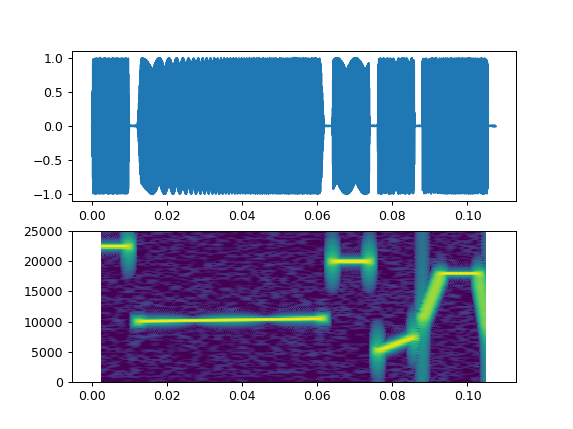

(<matplotlib.axes._subplots.AxesSubplot at 0x12f4d2b88>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12f592fc8>)

In [348]:
visualise_call(multicomp_call, syn_fs, fft_size=256)

In [349]:
fw = signal.hamming(int(0.0005*syn_fs))

In [350]:
analytical = signal.hilbert(multicomp_call)
p = PseudoWignerVilleDistribution(analytical, fwindow=fw)
a = p.run()
tf = a[0]
f = a[1]
peak_inds = np.apply_along_axis(np.argmax ,0,tf)
freqs = np.linspace(0, syn_fs*0.5, multicomp_call.size)
peak_freqs = freqs[peak_inds]

In [371]:
smooth_audio = moving_rms_edge_robust(multicomp_call, window_size=int(0.125*10**-3*fs)).flatten()
peakf_of_loud_parts = set_to_zero(smooth_audio, peak_freqs, 0.5)

v_high_freqs = 0.93*syn_fs*0.5
clean_peakf = peakf_of_loud_parts.copy()
clean_peakf[ clean_peakf >= v_high_freqs] = 0

med_clean  = median_filter(clean_peakf, syn_fs, medianfilter_size=0.25*10**-3)


In [372]:
23000/25000.0

0.92

<IPython.core.display.Javascript object>


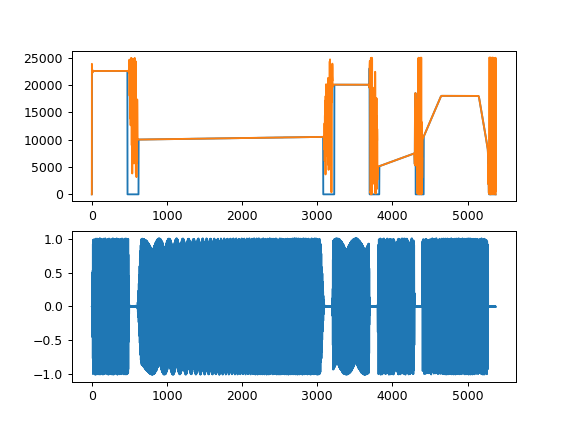

In [373]:
plt.figure()
a = plt.subplot(211)
plt.plot(clean_peakf)
plt.plot(peak_freqs)
plt.subplot(212, sharex=a)
plt.plot(multicomp_call)

In [323]:
import scipy.ndimage

In [324]:
above_zerofreq = clean_peakf.copy()

In [325]:
help(scipy.ndimage.label)

Help on function label in module scipy.ndimage.measurements:

label(input, structure=None, output=None)
    Label features in an array.
    
    Parameters
    ----------
    input : array_like
        An array-like object to be labeled.  Any non-zero values in `input` are
        counted as features and zero values are considered the background.
    structure : array_like, optional
        A structuring element that defines feature connections.
        `structure` must be centrosymmetric
        (see Notes).
        If no structuring element is provided,
        one is automatically generated with a squared connectivity equal to
        one.  That is, for a 2-D `input` array, the default structuring element
        is::
    
            [[0,1,0],
             [1,1,1],
             [0,1,0]]
    
    output : (None, data-type, array_like), optional
        If `output` is a data type, it specifies the type of the resulting
        labeled feature array.
        If `output` is an array-li

In [293]:
label_ids, num_objects = scipy.ndimage.label(above_zerofreq)
regions = scipy.ndimage.find_objects(label_ids)

In [326]:
above_zerofreq[regions[0]]

array([23897.46929661, 23148.49274284, 22720.50614068, 22487.90472646,
       22352.99590622, 22283.21548195, 22255.30331224, 22255.30331224,
       22278.56345367, 22315.77967994, 22362.29996278, 22408.82024563,
       22450.68850019, 22487.90472646, 22520.46892445, 22548.38109416,
       22566.98920729, 22580.94529215, 22585.59732043, 22590.24934872,
       22585.59732043, 22580.94529215, 22576.29326386, 22566.98920729,
       22557.68515073, 22553.03312244, 22543.72906587, 22539.07703759,
       22534.4250093 , 22534.4250093 , 22534.4250093 , 22534.4250093 ,
       22534.4250093 , 22539.07703759, 22543.72906587, 22548.38109416,
       22553.03312244, 22553.03312244, 22557.68515073, 22557.68515073,
       22562.33717901, 22557.68515073, 22557.68515073, 22557.68515073,
       22553.03312244, 22553.03312244, 22548.38109416, 22543.72906587,
       22543.72906587, 22543.72906587, 22539.07703759, 22539.07703759,
       22543.72906587, 22543.72906587, 22543.72906587, 22548.38109416,
      

<IPython.core.display.Javascript object>


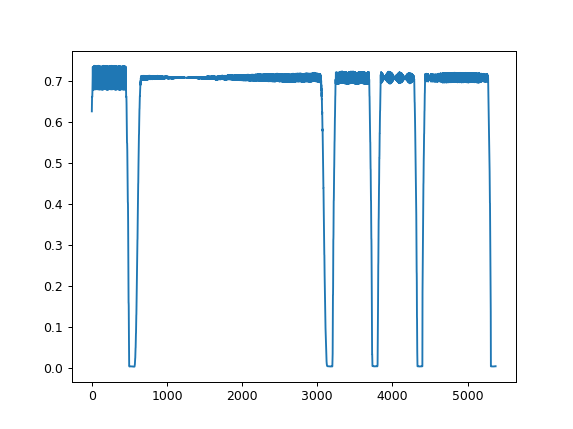

In [327]:
plt.figure()
plt.plot(smooth_audio)

<IPython.core.display.Javascript object>


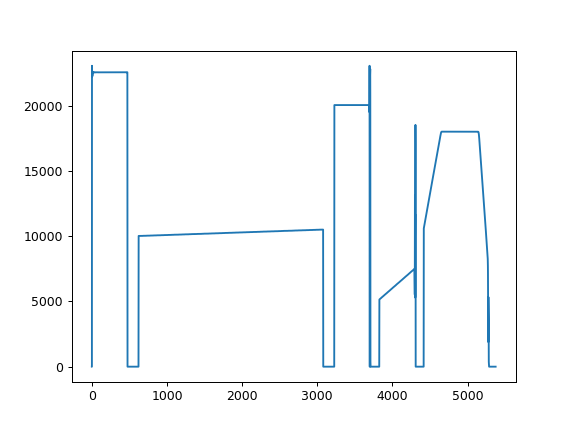

In [374]:
plt.figure()
plt.plot(clean_peakf)
#plt.plot(peak_freqs)

In [380]:
label_ids, num_objects = scipy.ndimage.label(clean_peakf)
regions = scipy.ndimage.find_objects(label_ids)
freq_profs = [ clean_peakf[each] for each in regions]

<IPython.core.display.Javascript object>


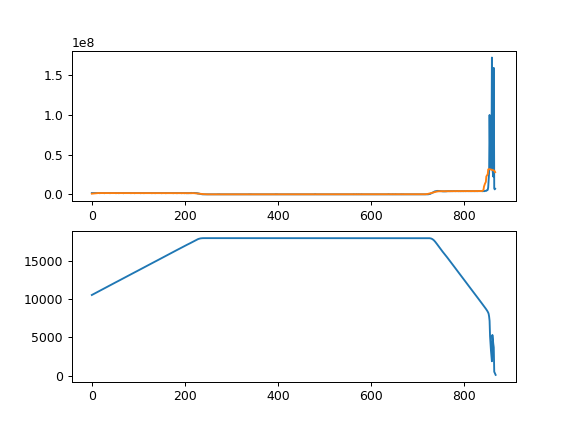

In [386]:
index = 5
win = int(syn_fs*0.0005)
delta_freq = abs(np.diff(freq_profs[index]))/(1.0/syn_fs)
smooth_deltafreq_profile = np.convolve(delta_freq, np.ones(int(win))/win,'same')

plt.figure()
a = plt.subplot(211)
plt.plot(delta_freq)
plt.plot(smooth_deltafreq_profile)
plt.subplot(212, sharex=a)
plt.plot(freq_profs[index])


In [357]:
500/0.05

10000.0

In [261]:
deltaf = abs(np.gradient(clean_peakf))

<IPython.core.display.Javascript object>


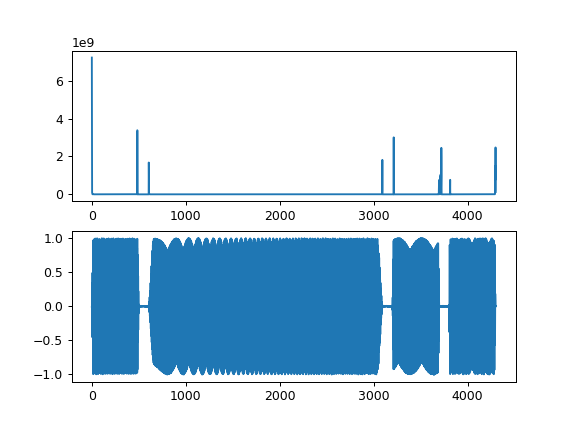

In [262]:
plt.figure()
a = plt.subplot(211)
plt.plot(deltaf/(1.0/fs))
plt.subplot(212, sharex=a)
plt.plot(multicomp_call)

<IPython.core.display.Javascript object>


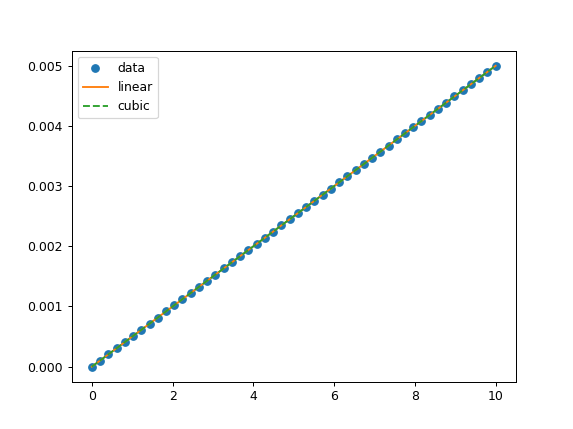

In [301]:


x = np.linspace(0, 10, endpoint=True)
y = np.linspace(0,0.005,x.size)
f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')



xnew = np.linspace(0, 10, num=41, endpoint=True)
plt.figure()
plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()



<IPython.core.display.Javascript object>


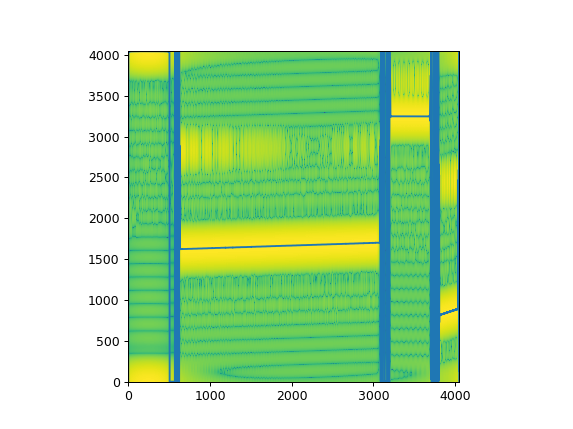

In [86]:
plt.figure()
plt.imshow(dB(abs(tf)), origin='lower')
plt.plot(peak_freq)

<IPython.core.display.Javascript object>


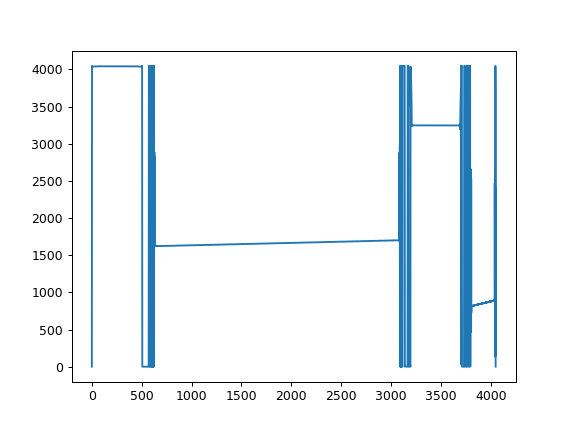

In [84]:
plt.figure()
plt.plot(peak_freq )

In [436]:
cf, fm,  fmr = segment_by_instant_frequency(multicomp_call, syn_fs, 
                             medianfilter_size=0.003,
                             noise_level=-44)

<IPython.core.display.Javascript object>


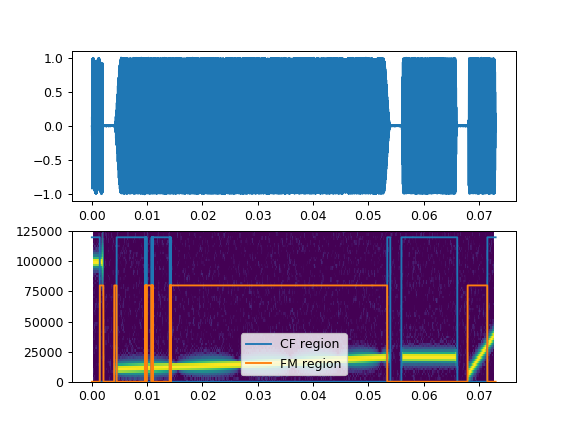

In [437]:
w, s = visualise_call(multicomp_call, syn_fs, fft_size=128);
s.plot(make_x_time(cf, syn_fs), cf*120000, label='CF region')
s.plot(make_x_time(cf, syn_fs), fm*80000, label='FM region')
s.set_ylim(0,125000)
s.legend()

<IPython.core.display.Javascript object>


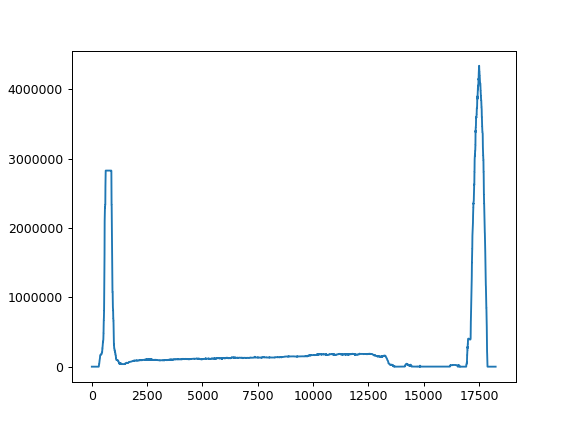

In [428]:
plt.figure()
plt.plot(fmr['fmrate'])

### Let's also mimic some of the bird calls I've seen on Xeno Canto:
eg. XC292537 (Golden Whistler)

In [429]:
# this bird call starts wth a CF, upFM and then CF at the end of the FM

cf = make_tone(1500, 0.01, 44100)
chirp1 = make_fm_chirp(1500, 3500, 0.005, 44100, 'linear')
cf2 = make_tone(3500, 0.01, 44100)

# this is actually a very weird way to create a call, theres a lot of abrupt transitions in the waveform..
# but if this works ..it's pretty neat. 

birdlike = np.concatenate((cf,chirp1,cf2))
add_noise(birdlike, -40);
birdlike /= np.max(birdlike)

<IPython.core.display.Javascript object>


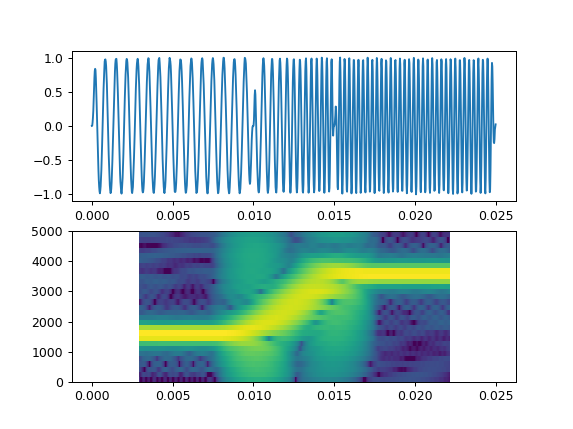

(0, 5000)

In [430]:
w,s = visualise_call(birdlike, 44100, fft_size=256)
s.set_ylim(0,5000)

<IPython.core.display.Javascript object>


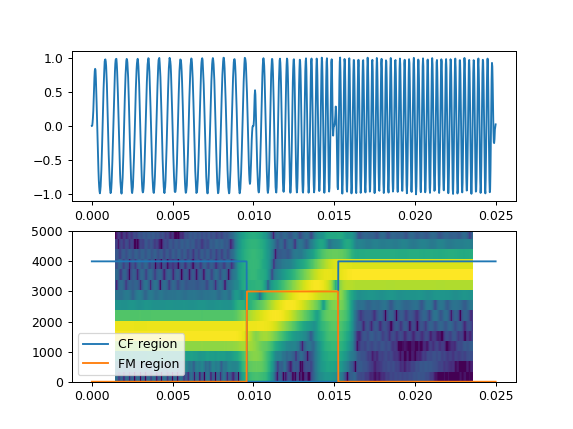

In [431]:
cf, fm,  fmr = segment_by_instant_frequency_modulation(birdlike, 44100, 
                             medianfilter_size=0.0015,
                             noise_level=-40)

w, s = visualise_call(birdlike, 44100, fft_size=128);
s.plot(make_x_time(cf, 44100), cf*4000, label='CF region')
s.plot(make_x_time(cf, 44100), fm*3000, label='FM region')
s.set_ylim(0,5000)
s.legend()

### What about multi syllable calls with very high and very low frequency components?

This is a kind of test to see if the current implementation will match my expectations. 

<IPython.core.display.Javascript object>


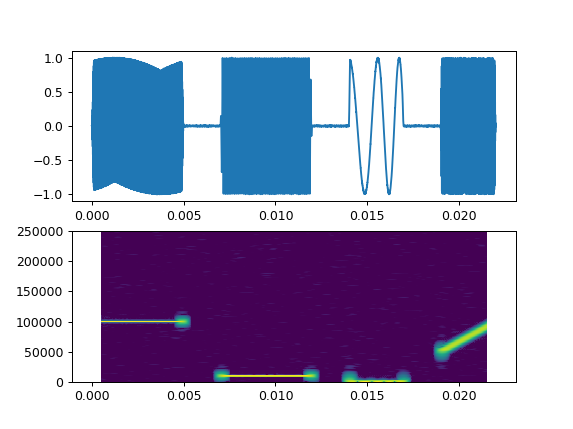

(<matplotlib.axes._subplots.AxesSubplot at 0x1db76ec8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1db9ad08>)

In [149]:
syn_fs

500000

c:\users\tbeleyur\google drive\holger goerlitz- imprs\phd_2015\projects and analyses\packages\measure_horseshoe_bat_calls\measure_horseshoe_bat_calls\view_horseshoebat_call.py:129: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


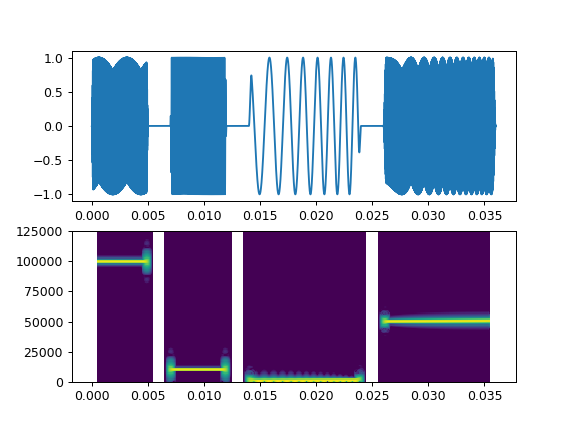

C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\matplotlib\axes\_axes.py:7747: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
c:\users\tbeleyur\google drive\holger goerlitz- imprs\phd_2015\projects and analyses\packages\measure_horseshoe_bat_calls\measure_horseshoe_bat_calls\signal_processing.py:13: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10(X)


In [280]:
syn_fs = 250000
high_cf = make_tone(100000, 0.005, syn_fs)
low_cf = make_tone(10000, 0.005, syn_fs)
low_fm = make_fm_chirp(500, 1000, 0.010, syn_fs)
high_fm = make_fm_chirp(50000, 50500, 0.010, syn_fs)

multi_call = np.concatenate((high_cf, silence(0.002, syn_fs), low_cf,
                            silence(0.002, syn_fs), low_fm, silence(0.002, syn_fs),
                            high_fm))
#add_noise(multi_call, -50); 

visualise_call(multi_call, syn_fs)

cf, fm,  fmr = segment_by_instant_frequency_modulation(multi_call, syn_fs, 
                             medianfilter_size=0.001,
                             noise_level=-38,
                             fm_limit=5000)

c:\users\tbeleyur\google drive\holger goerlitz- imprs\phd_2015\projects and analyses\packages\measure_horseshoe_bat_calls\measure_horseshoe_bat_calls\view_horseshoebat_call.py:129: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


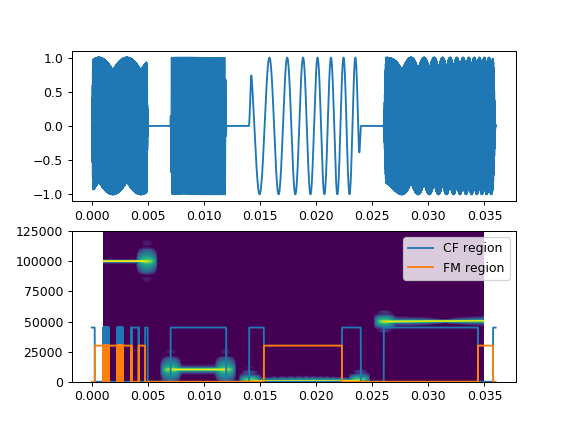

In [281]:
w, s = visualise_call(multi_call, syn_fs, fft_size=512);
s.plot(make_x_time(cf, syn_fs), cf*45000, label='CF region')
s.plot(make_x_time(cf, syn_fs), fm*30000, label='FM region')
s.set_ylim(0,125000)
s.legend()

In [282]:
from scipy.ndimage import filters

In [283]:
IF = instantaneous_frequency_profile(multi_call, syn_fs)
mIF = median_filter(IF, syn_fs, medianfilter_size=0.001)
delta_F = np.diff(mIF)
fmrate = abs(delta_F)/(1.0/syn_fs)
m_fmrate = filters.percentile_filter(fmrate, 10, int(0.0005*syn_fs))

C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


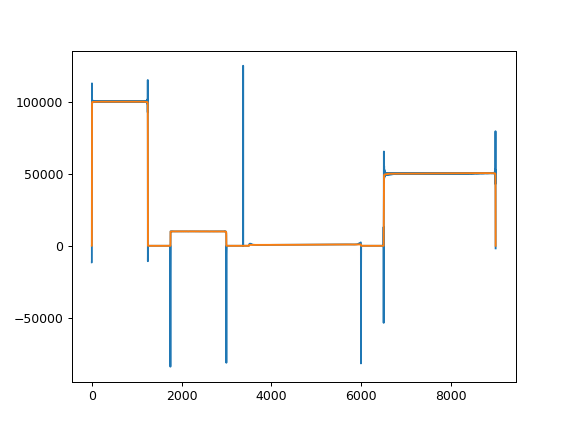

In [284]:
plt.figure()
plt.plot(IF)
plt.plot(mIF)

C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


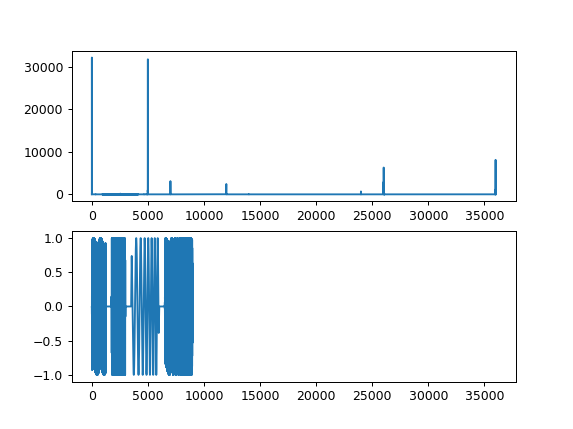

In [285]:
plt.figure()
a = plt.subplot(211)
plt.plot(abs(fm_rate))
#plt.plot(m_fmrate)
#plt.ylim(0,100000)
plt.subplot(212, sharex=a)
plt.plot(multi_call)

In [286]:
frequency_profile = np.copy(mIF)
fs = np.copy(syn_fs)
audio = np.copy(multi_call)
kwargs = {'medianfilter_size':0.001,
          'fm_limit':100000}
max_modulation = kwargs.get('fm_limit', 10000) # Hz/sec
relevant_band = kwargs.get('relevant_band', (0,fs*0.5))
min_f, max_f = relevant_band
noise_level = kwargs.get('noise_level', -60) # dB (20log10) re 1

# which parts of the frequency profile are within the relevant band
within_band = np.logical_and(frequency_profile>=min_f,
                             frequency_profile<=max_f)

# which parts of the audio are above the noise 
filtered_signal_level = median_filter(dB(np.abs(audio)), fs, **kwargs)
above_level =  filtered_signal_level > noise_level
above_noise_and_within_band = np.logical_and(above_level, within_band)

fm_rate = np.diff(frequency_profile)

#convert from delta Hz/sample to delta Hz/s
fm_rate_hz_sec = abs(fm_rate)/(1.0/fs)

clean_fmrate = filters.percentile_filter(fm_rate_hz_sec, 90, int(0.001*syn_fs))
clean_fmrate_resized = resize_by_adding_one_sample(clean_fmrate, 
                                                   frequency_profile, **kwargs)

below_fmrate = np.abs(clean_fmrate_resized)<= max_modulation
above_fmrate = np.invert(below_fmrate)

cfish_regions = np.zeros(clean_fmrate_resized.size, dtype='bool')
# choose only those regions which are:
# 1) above noise level 
# 2) have frequencies within band
# 3) have frequency modulations below/above the rate
cfish_regions =  np.logical_and(below_fmrate, above_noise_and_within_band)
fmish_regions = np.logical_and(above_fmrate, above_noise_and_within_band)


c:\users\tbeleyur\google drive\holger goerlitz- imprs\phd_2015\projects and analyses\packages\measure_horseshoe_bat_calls\measure_horseshoe_bat_calls\signal_processing.py:13: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10(X)


C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


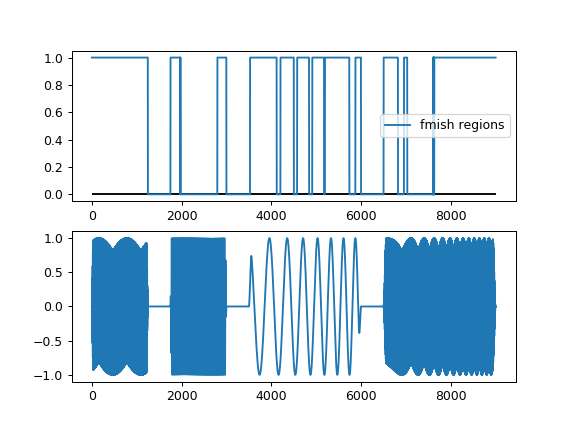

In [287]:
plt.figure()
plt.subplot(211)
#plt.plot(above_fmrate, label='above fm rate')
#plt.plot(above_noise_and_within_band, label='above nosie and within band')
plt.plot(fmish_regions, label='fmish regions')
#plt.plot(fm, label='fm')
#plt.plot(clean_fmrate/np.max(clean_fmrate), label='relative fmrate')

plt.hlines(5000/np.max(clean_fmrate), 0, clean_fmrate.size)
plt.legend()
plt.subplot(212)
plt.plot(multi_call)

### The FM rate calculation through instantaneous frequency tracking is dependent on the 

In [305]:
fs = 205000

high_cf = make_tone(100000, 0.005, fs)
low_cf = make_tone(10000, 0.005, fs)
low_fm = make_fm_chirp(500, 1000, 0.003, fs)
high_fm = make_fm_chirp(50000, 100000, 0.003, fs)

multi_call = np.concatenate((high_cf, silence(0.002, fs), low_cf,
                            silence(0.002, fs), low_fm, silence(0.002, fs),
                            high_fm))
add_noise(multi_call, -50); 

cf, fm,  fmr = segment_by_instant_frequency_modulation(multi_call, fs, 
                             medianfilter_size=0.002,
                             noise_level=-34,fm_limit=25000)

c:\users\tbeleyur\google drive\holger goerlitz- imprs\phd_2015\projects and analyses\packages\measure_horseshoe_bat_calls\measure_horseshoe_bat_calls\view_horseshoebat_call.py:129: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


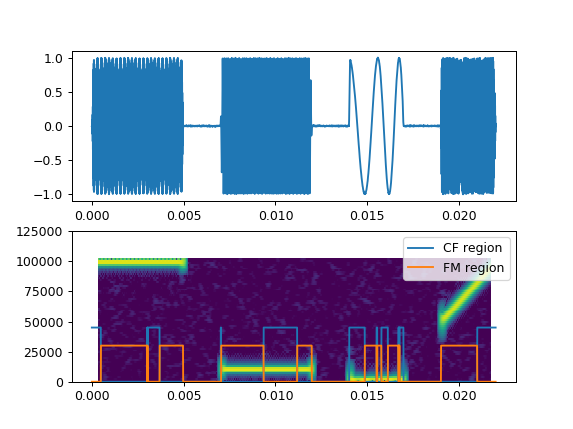

In [306]:
w, s = visualise_call(multi_call, fs, fft_size=128);
s.plot(make_x_time(cf, fs), cf*45000, label='CF region')
s.plot(make_x_time(cf, fs), fm*30000, label='FM region')
s.set_ylim(0,125000)
s.legend()

#### Now, let's remove the high frequency components completely, and also reduce the sampling frequency. 

In [354]:
fs = 20500

high_cf = make_tone(10000, 0.005, fs)
low_cf = make_tone(1000, 0.005, fs)
low_fm = make_fm_chirp(500, 1000, 0.050, fs)
high_fm = make_fm_chirp(5000, 5500, 0.050, fs)

multi_call = np.concatenate((high_cf, silence(0.002, fs), low_cf,
                            silence(0.002, fs), low_fm, silence(0.002, fs),
                            high_fm))
add_noise(multi_call, -50); 

cf, fm,  fmr = segment_by_instant_frequency_modulation(multi_call, fs, 
                             medianfilter_size=0.0005,
                             noise_level=-40, fm_limit=50000)

c:\users\tbeleyur\google drive\holger goerlitz- imprs\phd_2015\projects and analyses\packages\measure_horseshoe_bat_calls\measure_horseshoe_bat_calls\view_horseshoebat_call.py:129: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


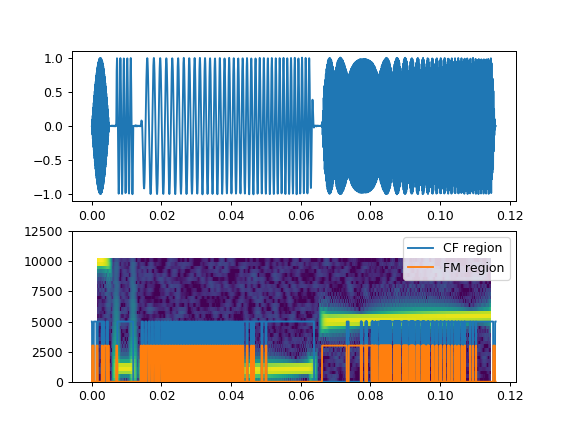

In [355]:
w, s = visualise_call(multi_call, fs, fft_size=64);
s.plot(make_x_time(cf, fs), cf*5000, label='CF region')
s.plot(make_x_time(cf, fs), fm*3000, label='FM region')
s.set_ylim(0,12500)
s.legend()

In [376]:
import tftb

In [378]:
import tftb.processing as proc

In [379]:
help(proc.inst_freq)

Help on function inst_freq in module tftb.processing.freq_domain:

inst_freq(x, t=None, L=1)
    Compute the instantaneous frequency of an analytic signal at specific
    time instants using the trapezoidal integration rule.
    
    :param x: The input analytic signal
    :param t: The time instants at which to calculate the instantaneous frequencies.
    :param L: Non default values are currently not supported.
        If L is 1, the normalized instantaneous frequency is computed. If L > 1,
        the maximum likelihood estimate of the instantaneous frequency of the
        deterministic part of the signal.
    :type x: numpy.ndarray
    :type t: numpy.ndarray
    :type L: int
    :return: instantaneous frequencies of the input signal.
    :rtype: numpy.ndarray
    :Example:
    >>> from tftb.generators import fmsin
    >>> x = fmsin(70, 0.05, 0.35, 25)[0]
    >>> instf, timestamps = inst_freq(x)
    >>> plot(timestamps, instf) #doctest: +SKIP
    
    .. plot:: docstring_plots/proc

In [389]:

medif_tftb = median_filter(if_tftb, syn_fs, medianfilter_size=0.001)

C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


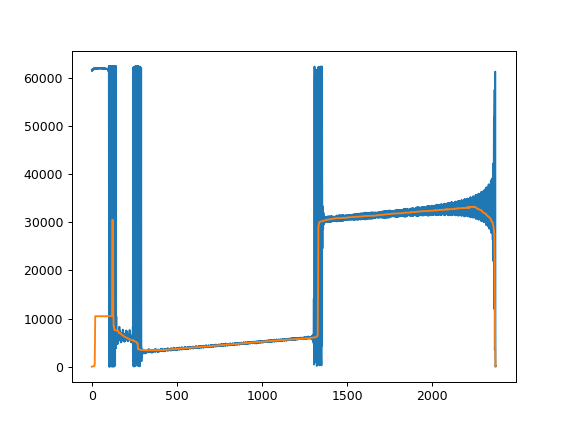

In [391]:
plt.figure()
plt.plot(if_tftb*syn_fs*0.5)
plt.plot(medif_tftb*syn_fs*0.5)

In [374]:
IF = instantaneous_frequency_profile(multi_call, fs)
delta_f = abs(np.diff(IF))
m_deltaf = median_filter(delta_f, fs, medianfilter_size=0.001)
mdeltaf = resize_by_adding_one_sample(m_deltaf, multi_call)
zeroed_mdeltaF = set_to_zero(abs(multi_call),mdeltaf, threshold=10**(-40/20.0))


C:\Users\tbeleyur\Anaconda2\envs\lim_int\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


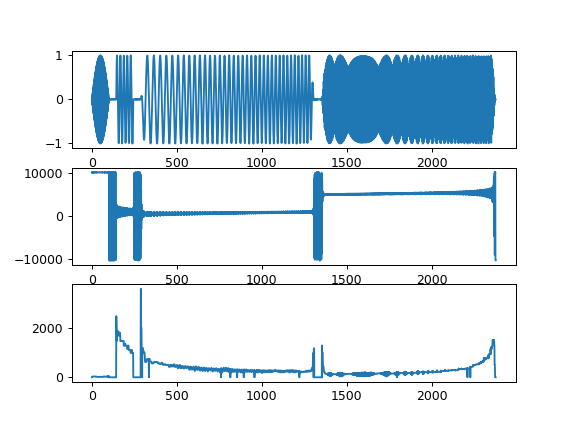

In [411]:
plt.figure()
a= plt.subplot(311)
plt.plot(multi_call)
plt.subplot(312, sharex=a)
plt.plot(IF)
plt.subplot(313, sharex=a)
plt.plot(zeroed_mdeltaF)


In [408]:
ifq,t = proc.inst_freq(multi_call)

In [417]:
from tftb.generators import fmlin
from tftb.processing.linear import gabor
import matplotlib.pyplot as plt
import numpy as np

N1 = 256
Ng = 33
Q = 1
sig = fmlin(N1)[0]
window = np.exp(np.log(0.005) * np.linspace(-1, 1, Ng) ** 2)
window = window / np.linalg.norm(window)
tfr, dgr, h = gabor(multi_call, 16, Q, window)

plt.figure()
plt.imshow(np.flipud(tfr), aspect='auto',
           interpolation='none')
plt.xlabel('Time')
plt.ylabel('Normalized frequency')
plt.title('Squared modulus of the Gabor coefficients')
plt.show()

ValueError: cannot reshape array of size 2377 into shape (16,148)

In [415]:
help(gabor)

Help on function gabor in module tftb.processing.linear:

gabor(signal, n_coeff=None, q_oversample=None, window=None)
    Compute the Gabor representation of a signal.
    
    :param signal: Singal to be analyzed.
    :param n_coeff: number of Gabor coefficients in time.
    :param q_oversample: Degree of oversampling
    :param window: Synthesis window
    :type signal: array-like
    :type n_coeff: integer
    :type q_oversample: int
    :type window: array-like
    :return: Tuple of Gabor coefficients, biorthogonal window associated with the synthesis window.
    :rtype: tuple

